#  1 | Introduction 

在本次竞赛中，我们的任务是预测非洲 497 个不同地点 2022 年的二氧化碳排放量。 在训练数据中，我们有 2019-2021 年的二氧化碳排放量
    
**本笔记本的内容：**
    
1.通过平滑消除2020年一次性的新冠疫情趋势。 或者，用 2019 年和 2021 年的平均值来估算 2020 年也是一种有效的方法，但此处未实施
    
2. 观察靠近最大排放位置的位置也具有较高的排放水平。 执行 K-Means 聚类以根据数据点的位置对数据点进行聚类。 这允许具有相似排放的数据点被分组在一起
    
3. 以 2019 年和 2020 年为训练数据，用一些集成模型进行实验，以测试其在 2021 年数据上的 CV

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from tqdm import tqdm
from sklearn.preprocessing import SplineTransformer
from holidays import CountryHoliday
from tqdm.notebook import tqdm
from typing import List



from category_encoders import OneHotEncoder, MEstimateEncoder, GLMMEncoder, OrdinalEncoder
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, KFold, RepeatedKFold, TimeSeriesSplit, train_test_split, cross_val_score
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, VotingRegressor, StackingRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor, LogisticRegression
from sklearn.linear_model import PassiveAggressiveRegressor, ARDRegression
from sklearn.linear_model import TheilSenRegressor, RANSACRegressor, HuberRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score, roc_curve
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler, LabelEncoder, SplineTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA
from xgboost import XGBRegressor, XGBClassifier
import lightgbm as lgbm
from lightgbm import LGBMRegressor, LGBMClassifier
from lightgbm import log_evaluation, early_stopping, record_evaluation
from catboost import CatBoostRegressor, CatBoostClassifier, Pool
from sklearn import set_config
from sklearn.multioutput import MultiOutputClassifier
from datetime import datetime, timedelta
import gc

import warnings
warnings.filterwarnings('ignore')

set_config(transform_output = 'pandas')

pal = sns.color_palette('viridis')

pd.set_option('display.max_rows', 100)

In [75]:
M = 1.07

# 2 | Examine Data 

**2.1**
    
在这里，我们试图平滑 2020 年的数据以消除新冠趋势
    
1.使用平滑导入的数据集
2. 使用 2019 年和 2021 年值的平均值 [https://www.kaggle.com/code/kacperrabczewski/rwanda-co2-step-by-step-guide]

In [76]:
extrp = pd.read_csv("./data/PS3E20_train_covid_updated")
extrp = extrp[(extrp["year"] == 2020)]

In [77]:
extrp

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
53,ID_-0.510_29.290_2020_00,-0.510,29.290,2020,0,0.000064,0.970290,0.000073,0.163462,-100.602665,...,5388.602054,60747.063530,4638.602176,6.287709,0.283116,-13.291375,33.679610,-140.309173,30.053447,3.753601
54,ID_-0.510_29.290_2020_01,-0.510,29.290,2020,1,NaN,NaN,NaN,NaN,NaN,...,6361.488754,53750.174162,5361.488754,19.167269,0.317732,-30.474972,48.119754,-139.437777,30.391957,4.051966
55,ID_-0.510_29.290_2020_02,-0.510,29.290,2020,2,-0.000361,0.668526,-0.000231,0.086199,73.269733,...,5320.715902,61012.625000,4320.715861,48.203733,0.265554,-12.461150,35.809728,-137.854449,29.100415,4.154116
56,ID_-0.510_29.290_2020_03,-0.510,29.290,2020,3,0.000597,0.553729,0.000331,0.149257,73.522247,...,6219.319294,55704.782998,5219.319269,12.809350,0.267030,16.381079,35.836898,-139.017754,26.265561,4.165751
57,ID_-0.510_29.290_2020_04,-0.510,29.290,2020,4,0.000107,1.045238,0.000112,0.224283,77.588455,...,6348.560006,54829.331776,5348.560014,35.283981,0.268983,-12.193650,47.092968,-134.474279,27.061321,4.233635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78965,ID_-3.299_30.301_2020_48,-3.299,30.301,2020,48,0.000114,1.123935,0.000125,0.149885,74.376836,...,6092.323722,57479.397776,5169.185142,15.331296,0.261608,16.309625,39.924967,-132.258700,30.393604,26.929207
78966,ID_-3.299_30.301_2020_49,-3.299,30.301,2020,49,0.000051,0.617927,0.000031,0.213135,72.364738,...,5992.053006,57739.300155,4992.053006,27.214085,0.276616,-0.287656,45.624810,-134.460418,30.911741,26.606790
78967,ID_-3.299_30.301_2020_50,-3.299,30.301,2020,50,-0.000235,0.633192,-0.000149,0.257000,-99.141518,...,6104.231241,56954.517231,5181.570213,26.270365,0.260574,-50.411241,37.645974,-132.193161,32.516685,27.256273
78968,ID_-3.299_30.301_2020_51,-3.299,30.301,2020,51,NaN,NaN,NaN,NaN,NaN,...,4855.537585,64839.955718,3858.187453,14.519789,0.248484,30.840922,39.529722,-138.964016,28.574091,25.591976


In [78]:
DATA_DIR = "./data/"
train = pd.read_csv(DATA_DIR + "train.csv")
test = pd.read_csv(DATA_DIR + "test.csv")

def add_features(df):
    #df["week"] = df["year"].astype(str) + "-" + df["week_no"].astype(str)
    #df["date"] = df["week"].apply(lambda x: get_date_from_week_string(x))
    #df = df.drop(columns = ["week"])
    df["week"] = (df["year"] - 2019) * 53 + df["week_no"]
    #df["lat_long"] = df["latitude"].astype(str) + "#" + df["longitude"].astype(str)
    return df

train = add_features(train)
test = add_features(test)

**2.2**
       
对预测进行一些有风险的后处理。
    
假设数据点的 MAX = max(2019 年排放量、2020 年排放量、2021 年排放量)。
    
如果 2021 年排放量 > 2019 年排放量，我们将 MAX * 1.07 分配给预测，否则我们只分配 MAX。 参考：https://www.kaggle.com/competitions/playground-series-s3e20/discussion/430152

In [79]:
vals = set()
for x in train[["latitude", "longitude"]].values:
    vals.add(tuple(x))
    
vals = list(vals)

In [80]:
zeros = []

for lat, long in vals:
    subset = train[(train["latitude"] == lat) & (train["longitude"] == long)]
    em_vals = subset["emission"].values
    if all(x == 0 for x in em_vals):
        zeros.append([lat, long])

In [81]:
test["2021_emission"] = test["week_no"]
test["2020_emission"] = test["week_no"]
test["2019_emission"] = test["week_no"]

for lat, long in vals:
    test.loc[(test.latitude == lat) & (test.longitude == long), "2021_emission"] = train.loc[(train.latitude == lat) & (train.longitude == long) & (train.year == 2021) & (train.week_no <= 48), "emission"].values
    test.loc[(test.latitude == lat) & (test.longitude == long), "2020_emission"] = train.loc[(train.latitude == lat) & (train.longitude == long) & (train.year == 2020) & (train.week_no <= 48), "emission"].values
    test.loc[(test.latitude == lat) & (test.longitude == long), "2019_emission"] = train.loc[(train.latitude == lat) & (train.longitude == long) & (train.year == 2019) & (train.week_no <= 48), "emission"].values
    #print(train.loc[(train.latitude == lat) & (train.longitude == long) & (train.year == 2021), "emission"])
    
test["ratio"] = (test["2021_emission"] / test["2019_emission"]).replace(np.nan, 0)
test["pos_ratio"] = test["ratio"].apply(lambda x: max(x, 1))
test["pos_ratio"] = test["pos_ratio"].apply(lambda x: 1.07 if x > 1 else x)
test["max"] = test[["2019_emission", "2020_emission", "2021_emission"]].max(axis=1)
test["lazy_pred"] = test["max"] * test["pos_ratio"]
test = test.drop(columns = ["ratio", "pos_ratio", "max", "2019_emission", "2020_emission", "2021_emission"])

In [82]:
train.loc[train.year == 2020, "emission"] = extrp

In [83]:
train

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission,week
0,ID_-0.510_29.290_2019_00,-0.510,29.290,2019,0,-0.000108,0.603019,-0.000065,0.255668,-98.593887,...,61085.809570,2615.120483,15.568533,0.272292,-12.628986,35.632416,-138.786423,30.752140,3.750994,0
1,ID_-0.510_29.290_2019_01,-0.510,29.290,2019,1,0.000021,0.728214,0.000014,0.130988,16.592861,...,66969.478735,3174.572424,8.690601,0.256830,30.359375,39.557633,-145.183930,27.251779,4.025176,1
2,ID_-0.510_29.290_2019_02,-0.510,29.290,2019,2,0.000514,0.748199,0.000385,0.110018,72.795837,...,60068.894448,3516.282669,21.103410,0.251101,15.377883,30.401823,-142.519545,26.193296,4.231381,2
3,ID_-0.510_29.290_2019_03,-0.510,29.290,2019,3,NaN,NaN,NaN,NaN,NaN,...,51064.547339,4180.973322,15.386899,0.262043,-11.293399,24.380357,-132.665828,28.829155,4.305286,3
4,ID_-0.510_29.290_2019_04,-0.510,29.290,2019,4,-0.000079,0.676296,-0.000048,0.121164,4.121269,...,63751.125781,3355.710107,8.114694,0.235847,38.532263,37.392979,-141.509805,22.204612,4.347317,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79018,ID_-3.299_30.301_2021_48,-3.299,30.301,2021,48,0.000284,1.195643,0.000340,0.191313,72.820518,...,60657.101913,4590.879504,20.245954,0.304797,-35.140368,40.113533,-129.935508,32.095214,29.404171,154
79019,ID_-3.299_30.301_2021_49,-3.299,30.301,2021,49,0.000083,1.130868,0.000063,0.177222,-12.856753,...,60168.191528,4659.130378,6.104610,0.314015,4.667058,47.528435,-134.252871,30.771469,29.186497,155
79020,ID_-3.299_30.301_2021_50,-3.299,30.301,2021,50,NaN,NaN,NaN,NaN,NaN,...,56596.027209,5222.646823,14.817885,0.288058,-0.340922,35.328098,-134.731723,30.716166,29.131205,156
79021,ID_-3.299_30.301_2021_51,-3.299,30.301,2021,51,-0.000034,0.879397,-0.000028,0.184209,-100.344827,...,46533.348194,6946.858022,32.594768,0.274047,8.427699,48.295652,-139.447849,29.112868,28.125792,157


In [84]:
test

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,week,lazy_pred
0,ID_-0.510_29.290_2022_00,-0.510,29.290,2022,0,NaN,NaN,NaN,NaN,NaN,...,41047.937500,7472.313477,7.935617,0.240773,-100.113792,33.697044,-133.047546,33.779583,159,3.753601
1,ID_-0.510_29.290_2022_01,-0.510,29.290,2022,1,0.000456,0.691164,0.000316,0.000000,76.239196,...,54915.708579,5476.147161,11.448437,0.293119,-30.510319,42.402593,-138.632822,31.012380,160,4.051966
2,ID_-0.510_29.290_2022_02,-0.510,29.290,2022,2,0.000161,0.605107,0.000106,0.079870,-42.055341,...,39006.093750,7984.795703,10.753179,0.267130,39.087361,45.936480,-144.784988,26.743361,161,4.231381
3,ID_-0.510_29.290_2022_03,-0.510,29.290,2022,3,0.000350,0.696917,0.000243,0.201028,72.169566,...,57646.368368,5014.724115,11.764556,0.304679,-24.465127,42.140419,-135.027891,29.604774,162,4.305286
4,ID_-0.510_29.290_2022_04,-0.510,29.290,2022,4,-0.000317,0.580527,-0.000184,0.204352,76.190865,...,52896.541873,5849.280394,13.065317,0.284221,-12.907850,30.122641,-135.500119,26.276807,163,4.347317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24348,ID_-3.299_30.301_2022_44,-3.299,30.301,2022,44,-0.000618,0.745549,-0.000461,0.234492,72.306198,...,55483.459980,5260.120056,30.398508,0.180046,-25.528588,45.284576,-116.521412,29.992562,203,30.327420
24349,ID_-3.299_30.301_2022_45,-3.299,30.301,2022,45,NaN,NaN,NaN,NaN,NaN,...,53589.917383,5678.951521,19.223844,0.177833,-13.380005,43.770351,-122.405759,29.017975,204,30.811167
24350,ID_-3.299_30.301_2022_46,-3.299,30.301,2022,46,NaN,NaN,NaN,NaN,NaN,...,62646.761340,4336.282491,13.801194,0.219471,-5.072065,33.226455,-124.530639,30.187472,205,31.162886
24351,ID_-3.299_30.301_2022_47,-3.299,30.301,2022,47,0.000071,1.003805,0.000077,0.205077,74.327427,...,50728.313991,6188.578464,27.887489,0.247275,-0.668714,45.885617,-129.006797,30.427455,206,31.439606


<div style="border-radius:10px; border:#FF0000 solid; padding: 15px; background-color: #F3f9ed; font-size:100%; text-align:left">
    
**Insights**
    
The train dataset has 79023 observations and the test dataset has 24353 observations. As we observe, some columns have null values

#  3 | EDA and Data Distribution

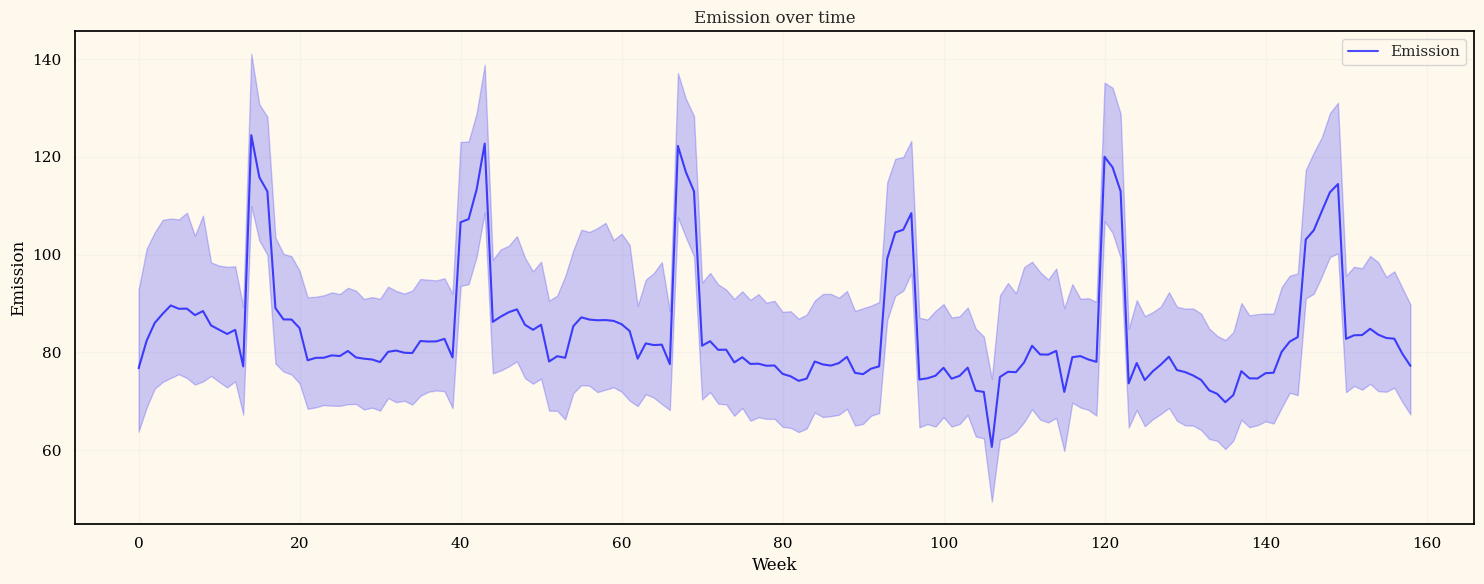

In [85]:
def plot_emission(train):
    
    plt.figure(figsize=(15, 6))
    sns.lineplot(data=train, x="week", y="emission", label="Emission", alpha=0.7, color='blue')

    plt.xlabel('Week')
    plt.ylabel('Emission')
    plt.title('Emission over time')

    plt.legend()
    plt.tight_layout()
    plt.show()
    
plot_emission(train)

<Axes: xlabel='emission', ylabel='Count'>

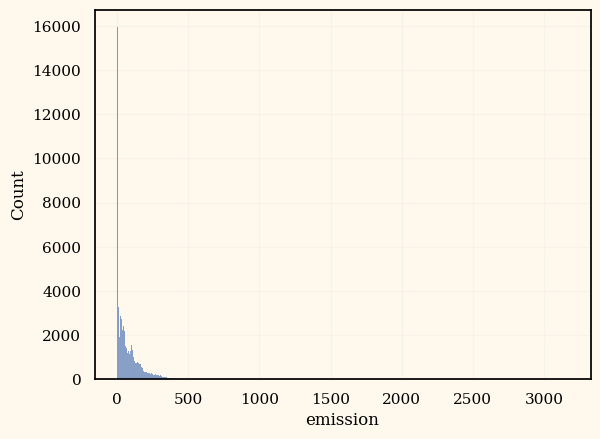

In [86]:
sns.histplot(train["emission"])

#  4 | Data Transformation 


In [87]:
print(len(vals))

497


 **Insights**
    
有 497 个独特的经纬度组合

<div style="border-radius:10px; border:#2e3ca5 solid; padding: 15px; background-color: #F3f9ed; font-size:100%; text-align:left">
    
**4.1**
    
Most of the features are just noise, we can remove them. (Reference: multiple discussion posts)

In [88]:
#train = train.drop(columns = ["ID_LAT_LON_YEAR_WEEK", "lat_long"])
#test = test.drop(columns = ["ID_LAT_LON_YEAR_WEEK", "lat_long"])

train = train[["latitude", "longitude", "year", "week_no", "emission"]]
test = test[["latitude", "longitude", "year", "week_no", "lazy_pred"]]

**4.2**
    
K Means Clustering + Distance to highest emission

In [89]:
#https://www.kaggle.com/code/lucasboesen/simple-catboost-6-features-cv-21-7
from sklearn.cluster import KMeans
import haversine as hs

km_train = train.groupby(by=['latitude', 'longitude'], as_index=False)['emission'].mean()
model = KMeans(n_clusters = 7, random_state = 42)
model.fit(km_train)
yhat_train = model.predict(km_train)
km_train['kmeans_group'] = yhat_train

""" Own Groups """
# Some locations have emission == 0
km_train['is_zero'] = km_train['emission'].apply(lambda x: 'no_emission_recorded' if x==0 else 'emission_recorded')

# Distance to the highest emission location
max_lat_lon_emission = km_train.loc[km_train['emission']==km_train['emission'].max(), ['latitude', 'longitude']]
km_train['distance_to_max_emission'] = km_train.apply(lambda x: hs.haversine((x['latitude'], x['longitude']), (max_lat_lon_emission['latitude'].values[0], max_lat_lon_emission['longitude'].values[0])), axis=1)

train = train.merge(km_train[['latitude', 'longitude', 'kmeans_group', 'distance_to_max_emission']], on=['latitude', 'longitude'])
test = test.merge(km_train[['latitude', 'longitude', 'kmeans_group', 'distance_to_max_emission']], on=['latitude', 'longitude'])
#train = train.drop(columns = ["latitude", "longitude"])
#test = test.drop(columns = ["latitude", "longitude"])

In [90]:
train

,latitude,longitude,year,week_no,emission,kmeans_group,distance_to_max_emission
0,-0.510,29.290,2019,0,3.750994,6,207.849890
1,-0.510,29.290,2019,1,4.025176,6,207.849890
2,-0.510,29.290,2019,2,4.231381,6,207.849890
3,-0.510,29.290,2019,3,4.305286,6,207.849890
4,-0.510,29.290,2019,4,4.347317,6,207.849890
...,...,...,...,...,...,...,...
79018,-3.299,30.301,2021,48,29.404171,6,157.630611
79019,-3.299,30.301,2021,49,29.186497,6,157.630611
79020,-3.299,30.301,2021,50,29.131205,6,157.630611
79021,-3.299,30.301,2021,51,28.125792,6,157.630611


In [91]:
test

,latitude,longitude,year,week_no,lazy_pred,kmeans_group,distance_to_max_emission
0,-0.510,29.290,2022,0,3.753601,6,207.849890
1,-0.510,29.290,2022,1,4.051966,6,207.849890
2,-0.510,29.290,2022,2,4.231381,6,207.849890
3,-0.510,29.290,2022,3,4.305286,6,207.849890
4,-0.510,29.290,2022,4,4.347317,6,207.849890
...,...,...,...,...,...,...,...
24348,-3.299,30.301,2022,44,30.327420,6,157.630611
24349,-3.299,30.301,2022,45,30.811167,6,157.630611
24350,-3.299,30.301,2022,46,31.162886,6,157.630611
24351,-3.299,30.301,2022,47,31.439606,6,157.630611


In [92]:
cat_params = {
    
    'n_estimators': 799, 
    'learning_rate': 0.09180872710592884,
    'depth': 8, 
    'l2_leaf_reg': 1.0242996861886846, 
    'subsample': 0.38227256755249117, 
    'colsample_bylevel': 0.7183481537623551,
    'random_state': 42,
    "silent": True,
}

lgb_params = {
    
    'n_estimators': 835, 
    'max_depth': 12, 
    'reg_alpha': 3.849279869880706, 
    'reg_lambda': 0.6840221712299135, 
    'min_child_samples': 10, 
    'subsample': 0.6810493885301987, 
    'learning_rate': 0.0916362259866008, 
    'colsample_bytree': 0.3133780298325982, 
    'colsample_bynode': 0.7966712089198238,
    "random_state": 42,
}

xgb_params = {
    
    "random_state": 42,
}

rf_params = {
    
    'n_estimators': 263, 
    'max_depth': 41, 
    'min_samples_split': 10, 
    'min_samples_leaf': 3,
    "random_state": 42,
    "verbose": 0
}

et_params = {
    
    "random_state": 42,
    "verbose": 0
}

#  5 | Validate Performance on 2021 data

In [93]:
def rmse(a, b):
    return mean_squared_error(a, b, squared=False)

In [94]:
validation = train[train.year == 2021]
clusters = train["kmeans_group"].unique()

for i in range(len(clusters)):
               
    cluster = clusters[i]
    
    print("==============================================")
    print(f" Cluster {cluster} ")
    
    
    train_c = train[train["kmeans_group"] == cluster]
    
    X_train = train_c[train_c.year < 2021].drop(columns = ["emission", "kmeans_group"])
    y_train = train_c[train_c.year < 2021]["emission"].copy()
    X_val = train_c[train_c.year >= 2021].drop(columns = ["emission", "kmeans_group"])
    y_val = train_c[train_c.year >= 2021]["emission"].copy()
    
    
    
    #=======================================================================================
    catboost_reg = CatBoostRegressor(**cat_params)
    catboost_reg.fit(X_train, y_train, eval_set=(X_val, y_val))

    catboost_pred = catboost_reg.predict(X_val) * M
    print(f"RMSE of CatBoost: {rmse(catboost_pred, y_val)}")

    #=======================================================================================
    lightgbm_reg = LGBMRegressor(**lgb_params,verbose=-1)
    lightgbm_reg.fit(X_train, y_train, eval_set=(X_val, y_val))

    lightgbm_pred = lightgbm_reg.predict(X_val) * M
    print(f"RMSE of LightGBM: {rmse(lightgbm_pred, y_val)}")

    #=======================================================================================
    xgb_reg = XGBRegressor(**xgb_params)
    xgb_reg.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose = False)

    xgb_pred = xgb_reg.predict(X_val) * M
    print(f"RMSE of XGBoost: {rmse(xgb_pred, y_val)}")

    #=======================================================================================
    rf_reg = RandomForestRegressor(**rf_params)
    rf_reg.fit(X_train, y_train)

    rf_pred = rf_reg.predict(X_val) * M
    print(f"RMSE of Random Forest: {rmse(rf_pred, y_val)}")

    #=======================================================================================
    et_reg = ExtraTreesRegressor(**et_params)
    et_reg.fit(X_train, y_train)

    et_pred = et_reg.predict(X_val) * M
    print(f"RMSE of Extra Trees: {rmse(et_pred, y_val)}")
    
    
    overall_pred = lightgbm_pred #(catboost_pred + lightgbm_pred) / 2
    validation.loc[validation["kmeans_group"] == cluster, "emission"] = overall_pred
    
    print(f"RMSE Overall: {rmse(overall_pred, y_val)}")

print("==============================================")
print(f"[DONE] RMSE of all clusters: {rmse(validation['emission'], train[train.year == 2021]['emission'])}")
print(f"[DONE] RMSE of all clusters Week 1-20: {rmse(validation[validation.week_no < 21]['emission'], train[(train.year == 2021) & (train.week_no < 21)]['emission'])}")
print(f"[DONE] RMSE of all clusters Week 21+: {rmse(validation[validation.week_no >= 21]['emission'], train[(train.year == 2021) & (train.week_no  >= 21)]['emission'])}")

 Cluster 6 
RMSE of CatBoost: 2.3575606902299895
RMSE of LightGBM: 2.2103640167714094
RMSE of XGBoost: 2.5018849673349863
RMSE of Random Forest: 2.6335510523545556
RMSE of Extra Trees: 3.0029623116826776
RMSE Overall: 2.2103640167714094
 Cluster 5 
RMSE of CatBoost: 19.175306730779514
RMSE of LightGBM: 17.910821889134688
RMSE of XGBoost: 19.6677120674706
RMSE of Random Forest: 18.856743714624777
RMSE of Extra Trees: 20.70417439300032
RMSE Overall: 17.910821889134688
 Cluster 1 
RMSE of CatBoost: 9.26195004601851
RMSE of LightGBM: 8.513309514506675
RMSE of XGBoost: 10.137965612920658
RMSE of Random Forest: 9.838001199034126
RMSE of Extra Trees: 11.043246766709913
RMSE Overall: 8.513309514506675
 Cluster 4 
RMSE of CatBoost: 44.564695183442716
RMSE of LightGBM: 43.946690922308754
RMSE of XGBoost: 50.18811358270916
RMSE of Random Forest: 46.39201148051631
RMSE of Extra Trees: 50.58999576441371
RMSE Overall: 43.946690922308754
 Cluster 0 
RMSE of CatBoost: 28.408461784012662
RMSE of LightG

#  6 | Predicting 2022 result

In [95]:
clusters = train["kmeans_group"].unique()

for i in tqdm(range(len(clusters))):
    
    cluster = clusters[i]
    
    train_c = train[train["kmeans_group"] == cluster]
    if "emission" in test.columns:
        test_c = test[test["kmeans_group"] == cluster].drop(columns = ["emission", "kmeans_group", "lazy_pred"])
    else:
        test_c = test[test["kmeans_group"] == cluster].drop(columns = ["kmeans_group", "lazy_pred"])
    
    X = train_c.drop(columns = ["emission", "kmeans_group"])
    y = train_c["emission"].copy()
    #=======================================================================================
    catboost_reg = CatBoostRegressor(**cat_params)
    catboost_reg.fit(X, y)
    #print(test_c)

    catboost_pred = catboost_reg.predict(test_c)

    #=======================================================================================
    lightgbm_reg = LGBMRegressor(**lgb_params,verbose=-1)
    lightgbm_reg.fit(X, y)
    #print(test_c)

    lightgbm_pred = lightgbm_reg.predict(test_c)

    #=======================================================================================
    #xgb_reg = XGBRegressor(**xgb_params)
    #xgb_reg.fit(X, y, verbose = False)

    #xgb_pred = xgb_reg.predict(test)

    #=======================================================================================
    rf_reg = RandomForestRegressor(**rf_params)
    rf_reg.fit(X, y)

    rf_pred = rf_reg.predict(test_c)

    #=======================================================================================
    #et_reg = ExtraTreesRegressor(**et_params)
    #et_reg.fit(X, y)

    #et_pred = et_reg.predict(test)

    overall_pred = lightgbm_pred #(catboost_pred + lightgbm_pred) / 2
    test.loc[test["kmeans_group"] == cluster, "emission"] = overall_pred

  0%|          | 0/7 [00:00<?, ?it/s]

In [96]:
test["emission"] = test["emission"] * 1.07

In [97]:
test.to_csv('submission.csv', index=False)